In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.linear_model import LinearRegression
from fill_data_gap_helpers import *

pd.set_option('display.max_rows', 8)
!


%load_ext autoreload
%autoreload 2

## Load data

In [2]:
path = 'lsff_estimated_data_plus_covariates.csv'

df = pd.read_csv(path)
df = df.drop(columns=['standard'])
df.columns = [i.replace(" ","_") for i in df.columns]

In [3]:
# replace pct pop eating vehicle with estimates
pct_pop_eating_vehicle = pd.read_csv('percent_of_population_eating_vehicle_estimates.csv')

# df = raw.drop(columns=['percent_of_population_eating_vehicle'])
df = df.rename(columns={'percent_of_population_eating_vehicle':'raw_pct_eating_vehicle'})
df = df.merge(pct_pop_eating_vehicle, on = ['location_name','vehicle'])

In [4]:
df['fortifiable_over_all'] = df.percent_of_population_eating_industrially_produced_vehicle / df.percent_of_population_eating_vehicle

In [5]:
# TODO: look into data for which pct eats vehicle < pct eats ind prod vehicle
df = df[~(df.raw_pct_eating_vehicle < df.percent_of_population_eating_industrially_produced_vehicle)]

In [6]:
df = df.drop(columns='raw_pct_eating_vehicle')

In [7]:
assert(len(df[df.fortifiable_over_all > 1])==0), "shouldnt estimate more people eat fortifiable than eat at all"

## set globals

In [8]:
estimation_vars = ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle']
shift = .01 #for logit transform

## pct pop eating fortifiable vehicle / pct pop eating vehicle

In [15]:
def setupReg(df, vehicle, use_logit):
    if use_logit:
        df = shift_logit(df, estimation_vars, shift)
    
    s = guess_mean_val(df, grouped_on = ['vehicle'], cols = ['percent_of_population_eating_vehicle','percent_of_population_eating_industrially_produced_vehicle',
                                                           'percent_of_population_eating_fortified_vehicle',
                                                           'sodium', 'whole_grains', 'sdi', 'hh_salt',
                                                           'fao_maize_and_products','fao_rice_and_products',
                                                           'fao_wheat_and_products', 'fao_oil_all'])
    s = s[s.vehicle==vehicle]

    nlocs = df.location_name.nunique()
    loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}
    s['backup_loc_name'] = s.location_name
    s.location_name = s.location_name.map(loc_map)
    
    #keeping nutrient as a predictor, because we're only estimating for locs where fortification is mandated
    #thus we're guessing same value across nutrients, for each location-vehicle pair
    nnutrs = s.nutrient.nunique()
    nut_map = {i:j for (i,j) in zip(s.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}
    s.nutrient = s.nutrient.map(nut_map)
    
    s = s.drop(columns=['location_id','vehicle','nutrient','percent_of_population_eating_industrially_produced_vehicle'])
    s = s.drop_duplicates()
    locs = s.backup_loc_name.tolist()
    s = s.drop(columns=['backup_loc_name'])
    
    X_full = np.array(s.drop(columns='fortifiable_over_all'))
    y_full = np.array(s.fortifiable_over_all)

    y = y_full[~np.isnan(y_full)]
    X = X_full[~np.isnan(y_full)]
    
    return X, y, X_full, y_full, locs

In [16]:
# def pair(x,y):
#     """cantor pairing fn"""
#     return 0.5*(x+y)*(x+y+1)+y

# def unpair(key):
#     """inverse of cantor pairing fn"""
#     w = np.floor((np.sqrt(8*key + 1)-1)/2)
#     t = (w**2 + w)/2
    
#     y = key - t
#     x = w - y
    
#     return x,y

In [17]:
# s['key'] = [pair(a,b) for (a,b) in zip(s.location_name,s.nutrient)]

In [18]:
def runReg(X, y):
    # randomly hold out a selection
    N = y.shape[0]
    select = np.random.choice(N, size = N - 1, replace = False)

    reg = LinearRegression().fit(X[select], y[select])

    holdout = np.array([i for i in range(N) if i not in select])
    preds = reg.predict(X[holdout])
    
    return holdout, preds

In [19]:
def plotReg(preds, holdout, use_logit, vehicle):
    if use_logit:
        backtransf_preds = (expit(preds) + shift) * 100
        backtransf_y = (expit(y[holdout]) + shift) * 100
        plt.scatter(backtransf_y, backtransf_preds)

        l,r,b,t = plt.axis()
        lb = min(0,l,b)
        ub = max(1,r,t)
        plt.plot([lb,ub], [lb,ub], 'k--')

        plt.title(f"out of sample validation: \npct of population that eats {vehicle}, using shifted logit tranform", fontsize = 15)    
    else:
        plt.scatter(y[holdout], preds)
        
        l,r,b,t = plt.axis()
        lb = min(0,l,b)
        ub = max(1,r,t)
        plt.plot([lb,ub], [lb,ub], 'k--')
        
        plt.title(f"out of sample validation: \npct of population that eats {vehicle}", fontsize = 15)

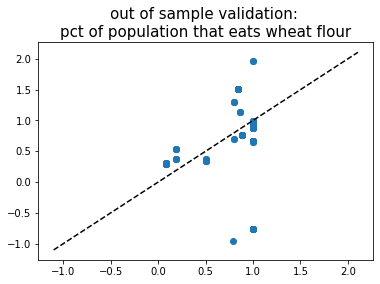

average error: 0.35
average clipped err: 0.29


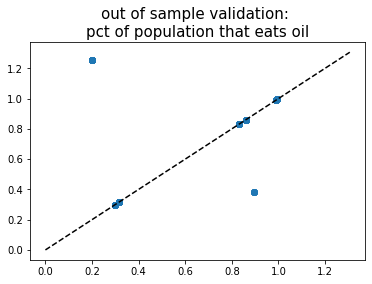

average error: 0.12
average clipped err: 0.12


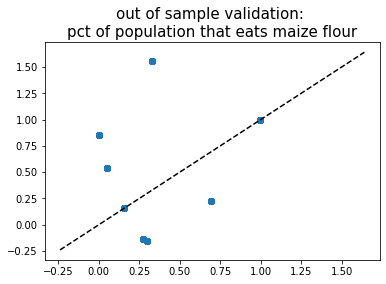

average error: 0.45
average clipped err: 0.43
avg overall error: 0.19
avg overall clipped error: 0.17


In [22]:
use_logit = False
total_err = 0
total_clipped_err = 0
for vehicle in ['wheat flour', 'oil', 'maize flour']:
    X, y, X_full, y_full, locs = setupReg(df, vehicle, use_logit)

    holdout, preds = runReg(X,y)
    for i in range(100):
        a, b = runReg(X,y)
        holdout = np.concatenate((holdout, a))
        preds = np.concatenate((preds, b))

    plotReg(preds, holdout, use_logit, vehicle)
    plt.show()
    
    err = sum(np.abs(y[holdout] - preds)) / len(holdout)
    total_err += err
    print(f'average error: {err:0.2f}')
    
    clipped_err = sum(np.abs(y[holdout] - np.clip(preds, 0, 100))) / len(holdout)
    total_clipped_err += clipped_err
    print(f'average clipped err: {clipped_err:0.2f}')

print(f'avg overall error: {total_err/5:0.2f}')
print(f'avg overall clipped error: {total_clipped_err/5:0.2f}')

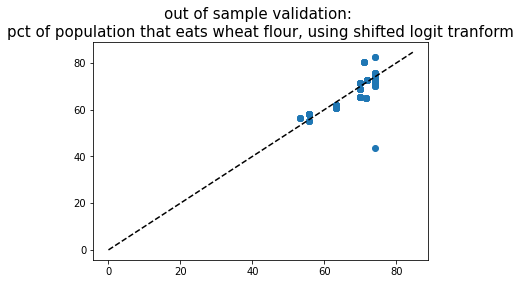

average error: 0.14
average clipped err: 0.13


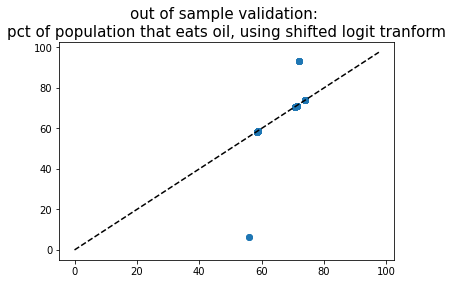

average error: 0.15
average clipped err: 0.10


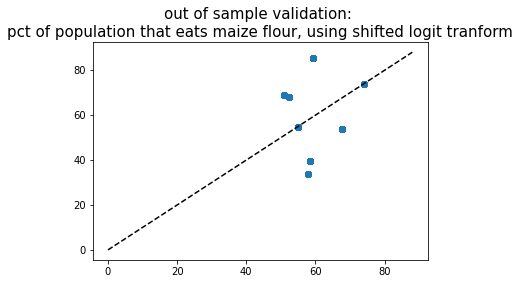

average error: 0.43
average clipped err: 0.32
avg overall error: 0.14
avg overall clipped error: 0.11


In [23]:
use_logit = True
total_err = 0
total_clipped_err = 0
for vehicle in ['wheat flour', 'oil', 'maize flour']:
    X, y, X_full, y_full, locs = setupReg(df, vehicle, use_logit)

    holdout, preds = runReg(X,y)
    for i in range(100):
        a, b = runReg(X,y)
        holdout = np.concatenate((holdout, a))
        preds = np.concatenate((preds, b))

    plotReg(preds, holdout, use_logit, vehicle)
    plt.show()
    
    err = sum(np.abs(y[holdout] - preds)) / len(holdout)
    total_err += err
    print(f'average error: {err:0.2f}')
    
    clipped_err = sum(np.abs(y[holdout] - np.clip(preds, 0, 100))) / len(holdout)
    total_clipped_err += clipped_err
    print(f'average clipped err: {clipped_err:0.2f}')

print(f'avg overall error: {total_err/5:0.2f}')
print(f'avg overall clipped error: {total_clipped_err/5:0.2f}')

In [216]:
## generate estimates

In [27]:
def estimate_nans(df, vehicle, use_logit, clip = True):
    
    # format for regression
    X, y, X_full, y_full, locs = setupReg(df, vehicle, use_logit)
    
    # run regression
    reg = LinearRegression().fit(X, y)
    
    # predict out
    preds = reg.predict(X_full)
    
    # populate missings with estimates
    y_full[np.isnan(y_full)] = preds[np.isnan(y_full)] 
    
    if use_logit:
        y_full = (expit(y_full) + shift) * 100
    
    if clip:
        y_full = np.clip(y_full, 0, 100)
    
    return pd.DataFrame({'location_name':locs,'vehicle':vehicle,'fortifiable_over_all':y_full})

In [28]:
estimates = pd.concat([estimate_nans(df, vehicle, use_logit = False, clip = True)
                       for vehicle in ['wheat flour', 'oil', 'maize flour', 'bouillon', 'rice']])

In [29]:
estimates

,location_name,vehicle,fortifiable_over_all
0,Angola,wheat flour,0.516409
1,Bangladesh,wheat flour,0.790000
2,Burkina Faso,wheat flour,1.000000
3,Burkina Faso,wheat flour,1.000000
...,...,...,...
5,Niger,bouillon,0.622928
6,Nigeria,bouillon,0.622928
0,Ghana,rice,0.500000
1,India,rice,0.500000


In [33]:
estimates = df.drop(columns='fortifiable_over_all').merge(estimates, on = ['location_name','vehicle'])

In [36]:
df['est_pct_fortifiable'] = estimates.percent_of_population_eating_vehicle * (1/estimates.fortifiable_over_all)

In [51]:
test = df.loc[(df.est_pct_fortifiable<101),['percent_of_population_eating_industrially_produced_vehicle','est_pct_fortifiable']].drop_duplicates()

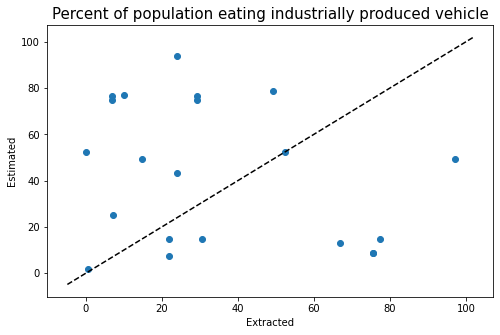

In [58]:

plt.figure(figsize=(8,5))

plt.scatter(test.percent_of_population_eating_industrially_produced_vehicle, test.est_pct_fortifiable)

l,r,b,t = plt.axis()
lb = min(0,l,b)
ub = max(1,r,t)
plt.plot([lb,ub], [lb,ub], 'k--')

plt.title("Percent of population eating industrially produced vehicle", fontsize = 15)
plt.xlabel('Extracted')
plt.ylabel('Estimated')
plt.show()